In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "UTC"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
Cillo2020_L028_HNSCC6_T0_AACTCAGCAGGTGGAT,Cillo2020,Cillo2020_L028,Cillo2020_HNSCC6_T0,3_GEX_V2,HNSCC,male,41-50,UTC,gdT_V2_Vγ9
Cillo2020_L028_HNSCC6_T0_AACTGGTGTTGTCGCG,Cillo2020,Cillo2020_L028,Cillo2020_HNSCC6_T0,3_GEX_V2,HNSCC,male,41-50,UTC,gdT_V2_Vγ9
Cillo2020_L028_HNSCC6_T0_ACGATACAGAGAACAG,Cillo2020,Cillo2020_L028,Cillo2020_HNSCC6_T0,3_GEX_V2,HNSCC,male,41-50,UTC,gdT_V1
Cillo2020_L028_HNSCC6_T0_ACTGATGGTGTTAAGA,Cillo2020,Cillo2020_L028,Cillo2020_HNSCC6_T0,3_GEX_V2,HNSCC,male,41-50,UTC,gdT_V1
Cillo2020_L028_HNSCC6_T0_AGCGTCGTCTAACCGA,Cillo2020,Cillo2020_L028,Cillo2020_HNSCC6_T0,3_GEX_V2,HNSCC,male,41-50,UTC,gdT_V2_Vγ9
...,...,...,...,...,...,...,...,...,...
Terekhova2023_L100_A29_T1_TTGGAACGTAGGCTGA,Terekhova2023,Terekhova2023_L100,Terekhova2023_A29_T1,5_GEX_V2,healthy,male,31-40,UTC,MAIT
Terekhova2023_L100_A29_T1_TTTATGCCAATAGAGT,Terekhova2023,Terekhova2023_L100,Terekhova2023_A29_T1,5_GEX_V2,healthy,male,31-40,UTC,MAIT
Terekhova2023_L100_A29_T1_TTTATGCTCGGCGCAT,Terekhova2023,Terekhova2023_L100,Terekhova2023_A29_T1,5_GEX_V2,healthy,male,31-40,UTC,gdT_V2_Vγ9


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
9,2,4,0.251183,0.596294,0.149779
7,2,1,0.242716,0.660182,0.160237
8,2,3,0.239894,0.681479,0.163483
11,3,2,0.239894,1.000000,0.239894
4,1,2,0.242716,1.000000,0.242716
14,4,2,0.251183,1.000000,0.251183
1,0,2,0.256828,1.000000,0.256828
10,3,1,0.447025,0.660182,0.295118
5,1,3,0.447025,0.681479,0.304638
2,0,3,0.619110,0.681479,0.421910


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

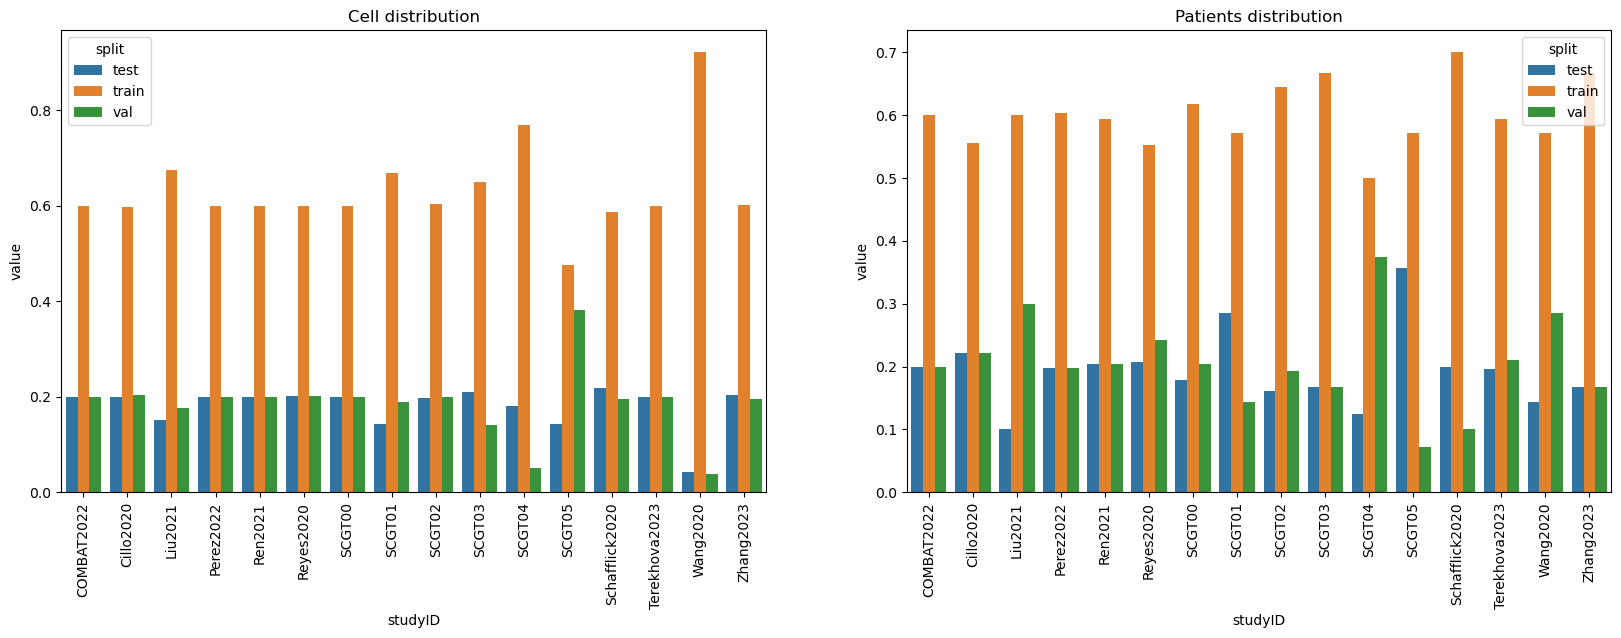

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((69660, 935), (22483, 935), (22954, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((69660,), (22483,), (22954,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-17 18:04:10,337] A new study created in memory with name: no-name-969a1d6c-59a8-4ab2-b779-4e266d162640


/tmp/ipykernel_1050234/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250317_180411-jt96mpqw
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_UTC


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/jt96mpqw


[I 2025-03-17 18:04:21,415] Trial 0 finished with value: -0.954435 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.954435.


[I 2025-03-17 18:04:39,015] Trial 1 finished with value: -0.994837 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.994837.


[I 2025-03-17 18:04:46,212] Trial 2 finished with value: -0.959741 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 1 with value: -0.994837.


[I 2025-03-17 18:06:03,518] Trial 3 finished with value: -0.990612 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 1 with value: -0.994837.


[I 2025-03-17 18:07:14,547] Trial 4 finished with value: -0.993742 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 1 with value: -0.994837.


[I 2025-03-17 18:07:25,329] Trial 5 pruned. Trial was pruned at iteration 30.


[I 2025-03-17 18:07:31,421] Trial 6 finished with value: -0.990304 and parameters: {'max_depth': 13, 'min_child_weight': 43, 'subsample': 0.1585464336867516, 'colsample_bynode': 0.9539969835279999, 'learning_rate': 0.4038423798071558}. Best is trial 1 with value: -0.994837.


[I 2025-03-17 18:07:33,252] Trial 7 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:35,127] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:36,603] Trial 9 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:50,851] Trial 10 finished with value: -0.997413 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9725833997090791, 'colsample_bynode': 0.11616568805333755, 'learning_rate': 0.17780618353487967}. Best is trial 10 with value: -0.997413.


[I 2025-03-17 18:08:01,493] Trial 11 finished with value: -0.995336 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.9818290990185045, 'colsample_bynode': 0.17702656156719, 'learning_rate': 0.11568531411766632}. Best is trial 10 with value: -0.997413.


[I 2025-03-17 18:08:03,997] Trial 12 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:06,076] Trial 13 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:08,386] Trial 14 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:26,761] Trial 15 finished with value: -0.995612 and parameters: {'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.719264024177087, 'colsample_bynode': 0.2540835086298475, 'learning_rate': 0.03987682305667138}. Best is trial 10 with value: -0.997413.


[I 2025-03-17 18:08:29,674] Trial 16 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:31,825] Trial 17 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:40,356] Trial 18 pruned. Trial was pruned at iteration 41.


[I 2025-03-17 18:08:42,375] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:44,206] Trial 20 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:55,925] Trial 21 pruned. Trial was pruned at iteration 50.


[I 2025-03-17 18:08:57,648] Trial 22 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:00,012] Trial 23 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 18:09:09,545] Trial 24 pruned. Trial was pruned at iteration 41.


[I 2025-03-17 18:09:11,372] Trial 25 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:13,384] Trial 26 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:15,057] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:16,920] Trial 28 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:18,956] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:22,034] Trial 30 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:29,732] Trial 31 pruned. Trial was pruned at iteration 41.


[I 2025-03-17 18:09:38,278] Trial 32 pruned. Trial was pruned at iteration 41.


[I 2025-03-17 18:09:48,099] Trial 33 pruned. Trial was pruned at iteration 41.


[I 2025-03-17 18:09:50,020] Trial 34 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:52,130] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:53,747] Trial 36 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:10:03,204] Trial 37 pruned. Trial was pruned at iteration 41.


[I 2025-03-17 18:10:05,826] Trial 38 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 18:10:07,875] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:10:15,636] Trial 40 pruned. Trial was pruned at iteration 41.


[I 2025-03-17 18:10:18,222] Trial 41 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 18:10:20,661] Trial 42 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:10:33,066] Trial 43 pruned. Trial was pruned at iteration 39.


[I 2025-03-17 18:10:35,235] Trial 44 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 18:10:38,799] Trial 45 pruned. Trial was pruned at iteration 15.


[I 2025-03-17 18:10:50,073] Trial 46 finished with value: -0.995745 and parameters: {'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.9628883059554308, 'colsample_bynode': 0.34893706360135723, 'learning_rate': 0.05663744292474434}. Best is trial 10 with value: -0.997413.


[I 2025-03-17 18:10:58,154] Trial 47 pruned. Trial was pruned at iteration 41.


[I 2025-03-17 18:11:00,766] Trial 48 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:11:20,018] Trial 49 finished with value: -0.996017 and parameters: {'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.9796155488204317, 'colsample_bynode': 0.21008388449988175, 'learning_rate': 0.09325964258199478}. Best is trial 10 with value: -0.997413.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_UTC_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:1.50685	validation_0-custom_f1_score:-0.97680


[1]	validation_0-mlogloss:1.16712	validation_0-custom_f1_score:-0.98261


[2]	validation_0-mlogloss:0.93831	validation_0-custom_f1_score:-0.98696


[3]	validation_0-mlogloss:0.76788	validation_0-custom_f1_score:-0.99021


[4]	validation_0-mlogloss:0.63612	validation_0-custom_f1_score:-0.99262


[5]	validation_0-mlogloss:0.53046	validation_0-custom_f1_score:-0.99437


[6]	validation_0-mlogloss:0.44558	validation_0-custom_f1_score:-0.99501


[7]	validation_0-mlogloss:0.37567	validation_0-custom_f1_score:-0.99569


[8]	validation_0-mlogloss:0.31773	validation_0-custom_f1_score:-0.99586


[9]	validation_0-mlogloss:0.27022	validation_0-custom_f1_score:-0.99604


[10]	validation_0-mlogloss:0.22950	validation_0-custom_f1_score:-0.99636


[11]	validation_0-mlogloss:0.19584	validation_0-custom_f1_score:-0.99666


[12]	validation_0-mlogloss:0.16699	validation_0-custom_f1_score:-0.99710


[13]	validation_0-mlogloss:0.14284	validation_0-custom_f1_score:-0.99755


[14]	validation_0-mlogloss:0.12260	validation_0-custom_f1_score:-0.99795


[15]	validation_0-mlogloss:0.10530	validation_0-custom_f1_score:-0.99827


[16]	validation_0-mlogloss:0.09089	validation_0-custom_f1_score:-0.99858


[17]	validation_0-mlogloss:0.07851	validation_0-custom_f1_score:-0.99871


[18]	validation_0-mlogloss:0.06800	validation_0-custom_f1_score:-0.99889


[19]	validation_0-mlogloss:0.05915	validation_0-custom_f1_score:-0.99897


[20]	validation_0-mlogloss:0.05159	validation_0-custom_f1_score:-0.99906


[21]	validation_0-mlogloss:0.04518	validation_0-custom_f1_score:-0.99920


[22]	validation_0-mlogloss:0.03974	validation_0-custom_f1_score:-0.99929


[23]	validation_0-mlogloss:0.03509	validation_0-custom_f1_score:-0.99938


[24]	validation_0-mlogloss:0.03116	validation_0-custom_f1_score:-0.99942


[25]	validation_0-mlogloss:0.02780	validation_0-custom_f1_score:-0.99942


[26]	validation_0-mlogloss:0.02487	validation_0-custom_f1_score:-0.99955


[27]	validation_0-mlogloss:0.02242	validation_0-custom_f1_score:-0.99964


[28]	validation_0-mlogloss:0.02016	validation_0-custom_f1_score:-0.99960


[29]	validation_0-mlogloss:0.01846	validation_0-custom_f1_score:-0.99947


[30]	validation_0-mlogloss:0.01675	validation_0-custom_f1_score:-0.99947


[31]	validation_0-mlogloss:0.01543	validation_0-custom_f1_score:-0.99947


[32]	validation_0-mlogloss:0.01399	validation_0-custom_f1_score:-0.99955


[33]	validation_0-mlogloss:0.01301	validation_0-custom_f1_score:-0.99955


[34]	validation_0-mlogloss:0.01214	validation_0-custom_f1_score:-0.99955


[35]	validation_0-mlogloss:0.01132	validation_0-custom_f1_score:-0.99951


[36]	validation_0-mlogloss:0.01045	validation_0-custom_f1_score:-0.99942


[37]	validation_0-mlogloss:0.00987	validation_0-custom_f1_score:-0.99942


[38]	validation_0-mlogloss:0.00923	validation_0-custom_f1_score:-0.99938


[39]	validation_0-mlogloss:0.00866	validation_0-custom_f1_score:-0.99942


[40]	validation_0-mlogloss:0.00812	validation_0-custom_f1_score:-0.99942


[41]	validation_0-mlogloss:0.00780	validation_0-custom_f1_score:-0.99942


[42]	validation_0-mlogloss:0.00748	validation_0-custom_f1_score:-0.99942


[43]	validation_0-mlogloss:0.00700	validation_0-custom_f1_score:-0.99946


[44]	validation_0-mlogloss:0.00671	validation_0-custom_f1_score:-0.99960


[45]	validation_0-mlogloss:0.00663	validation_0-custom_f1_score:-0.99960


[46]	validation_0-mlogloss:0.00639	validation_0-custom_f1_score:-0.99964


[47]	validation_0-mlogloss:0.00602	validation_0-custom_f1_score:-0.99969


[48]	validation_0-mlogloss:0.00572	validation_0-custom_f1_score:-0.99969


[49]	validation_0-mlogloss:0.00558	validation_0-custom_f1_score:-0.99969


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.11616568805333755,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x7fe59aaf6700>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.17780618353487967, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_UTC_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[18:11:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


